In [67]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import heapq

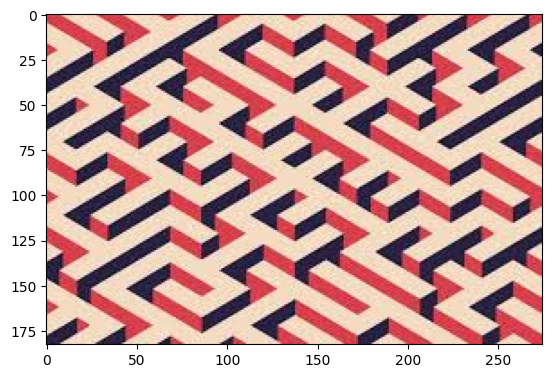

(183, 275, 3)


In [68]:
img=cv.imread("./pattern4.jpg")
img=cv.cvtColor(img,cv.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
print(img.shape)

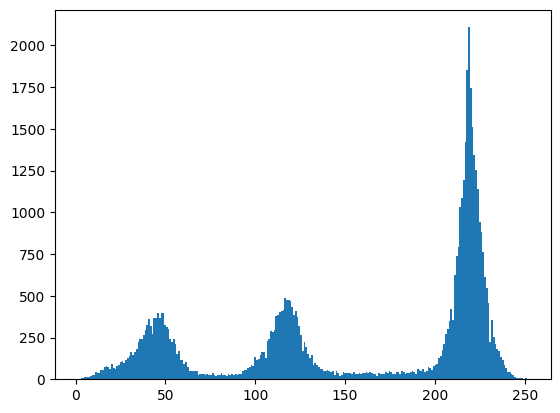

In [69]:
vals=img.mean(axis=2).flatten()
plt.hist(vals,bins=255)
plt.show()

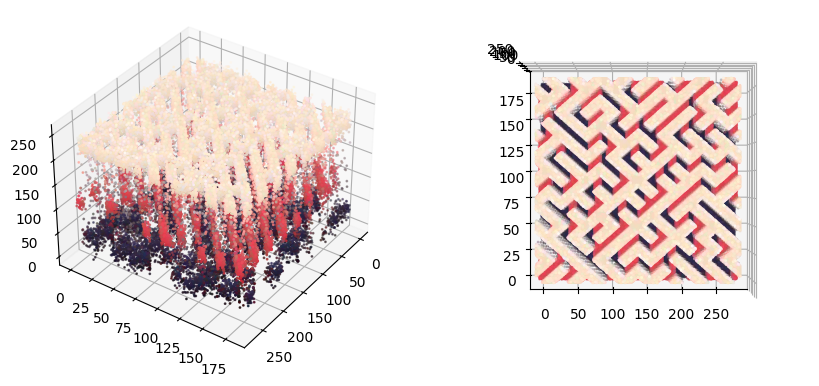

In [70]:
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.view_init(35,35)
ax2.view_init(90,0,90)

x=[]
y=[]
z=[]

for i in range(img.shape[0]):
    x.append(i)
for i in range(img.shape[1]):
    y.append(i)

X,Y=np.meshgrid(y,x)
Z = np.dot(img[:,:,:], [0.2989, 0.5870, 0.1140])

colors = img.reshape(-1, 3) / 255.0

ax1.scatter(
    X.flatten(),
    Y.flatten(),
    Z.flatten(),
    c=colors,
    s=1
)
ax2.scatter(
    X.flatten(),
    Y.flatten(),
    Z.flatten(),
    c=colors,
    s=1
)
plt.show()

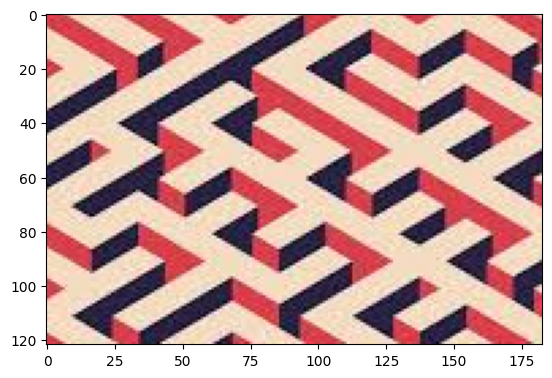

(122, 183, 3)


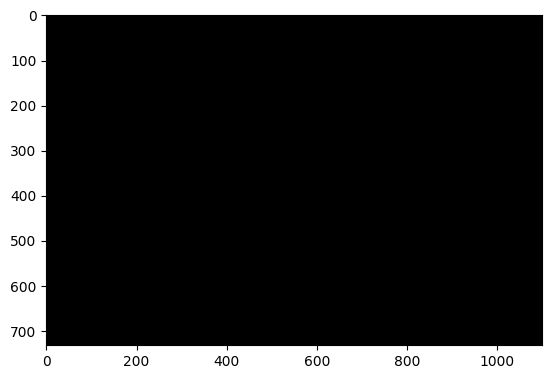

(732, 1100, 3)


In [71]:
synthesis_img_size=(img.shape[0]*4,img.shape[1]*4,3)
block_size=(int(img.shape[0]/1.5),int(img.shape[1]/1.5),3)

synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

plt.imshow(img[:block_size[0],:block_size[1]])
plt.show()
print(img[:block_size[0],:block_size[1]].shape)
plt.imshow(synthesis_img)
plt.show()
print(synthesis_img.shape)

### Generic Block Tiling

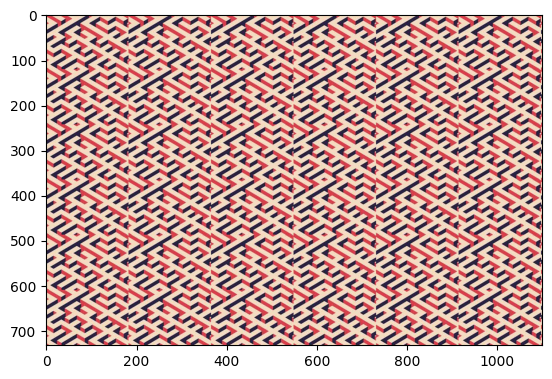

In [72]:
for i in range(0,synthesis_img.shape[0]):
    for j in range(0,synthesis_img.shape[1]):
        synthesis_img[i,j]=img[i%block_size[0],j%block_size[1]]
plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling

In [73]:
def get_random_patch(img,synthesis_img_size,block_size,y,x):
    offset=(np.random.randint(0,img.shape[0]-block_size[0]),np.random.randint(0,img.shape[1]-block_size[1]))
    fill_size=list(block_size)
    if(y+block_size[0]>=synthesis_img_size[0]):
        fill_size[0]=synthesis_img_size[0]-y
    if(x+block_size[1]>=synthesis_img_size[1]):
        fill_size[1]=synthesis_img_size[1]-x
    patch=np.astype(img[offset[0]:offset[0]+fill_size[0],offset[1]:offset[1]+fill_size[1]],np.uint8)

    return patch

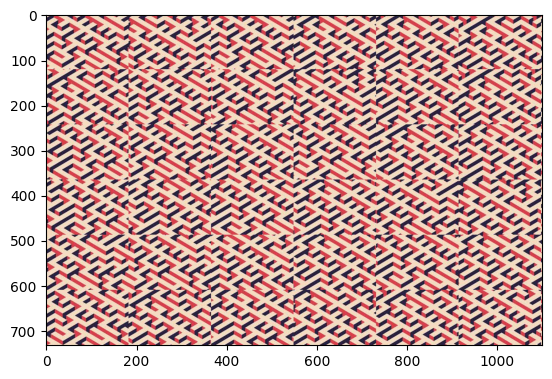

In [74]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

for y in range(0,synthesis_img.shape[0],block_size[0]):
    for x in range(0,synthesis_img.shape[1],block_size[1]):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch
plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling with Boundary Overlap

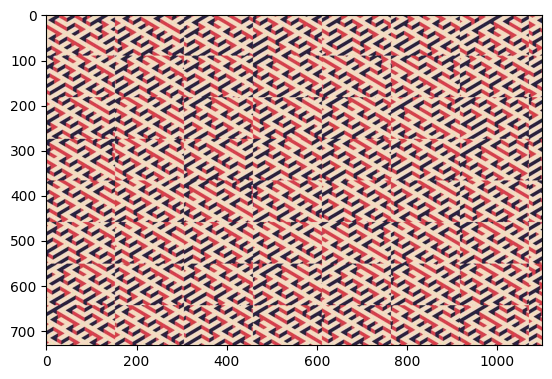

In [79]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=30
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch

plt.imshow(synthesis_img)
plt.show()

### Random Block Tiling with Boundary Overlap and Minimum Boundary Cut

In [ ]:
#Djikstra's Algorithm in the vertical direction and the destination is any node at a depth h
def min_cut_path(errors):
    pq=[(error,[i]) for i,error in enumerate(errors[0])]
    heapq.heapify(pq)
    h,w=errors.shape
    visited=set()
    while pq:
        error,path=heapq.heappop(pq)
        current_depth=len(path)
        current_index=path[-1]
        if current_depth==h:
            return path
        for i in -1,0,1:
            next_index=current_index+i
            if 0<=next_index<w:
                if(current_depth,next_index) not in visited:
                    cumError=error+errors[current_depth,next_index]
                    heapq.heappush(pq,(cumError,path+[next_index]))
                    visited.add((current_depth,next_index))

In [ ]:
def min_cut_patch(patch,overlap,synthesis_img,y,x):
    patch=patch.copy()
    min_cut=np.zeros_like(patch,dtype=bool)

    if x>0:
        left=patch[:,:overlap]-synthesis_img[y:y+patch.shape[0],x:x+overlap]
        leftL2=np.sum(left**2,axis=2)
        # print(leftL2)
        # print(leftL2.shape)
        for i,j in enumerate(min_cut_path(leftL2)):
            min_cut[i,:j]=True
    if y>0:
        up=patch[:overlap,:]-synthesis_img[y:y+overlap,x:x+patch.shape[1]]
        upL2=np.sum(up**2,axis=2)
        # print(upL2)
        # print(upL2.shape)
        for j,i in enumerate(min_cut_path(upL2.T)):
            min_cut[:i,j]=True

    np.copyto(patch, synthesis_img[y:y+patch.shape[0], x:x+patch.shape[1]], where=min_cut)

    return patch

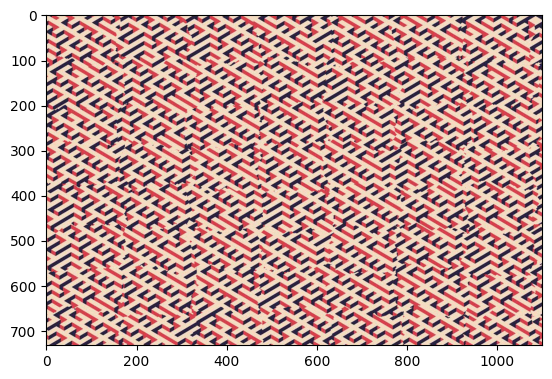

In [78]:
synthesis_img=np.zeros(synthesis_img_size).astype(np.uint8)

overlap=30
for y in range(0,synthesis_img.shape[0],block_size[0]-overlap):
    for x in range(0,synthesis_img.shape[1],block_size[1]-overlap):
        patch=get_random_patch(img,synthesis_img_size,block_size,y,x)
        patch=min_cut_patch(patch,overlap,synthesis_img,y,x)
        synthesis_img[y:y+block_size[0],x:x+block_size[1]]=patch
plt.imshow(synthesis_img)
plt.show()

### Best Block Tiling with Boundary Overlap

In [ ]:
def get_best_patch():
    pass